#Different approaches for Code Smells detection

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
!pip install torch

In [4]:
!git clone https://github.com/bentrevett/code2vec.git

fatal: destination path 'code2vec' already exists and is not an empty directory.


In [5]:
# Import delle librerie necessarie
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
import nltk
import re
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch as pt
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, jaccard_score, hamming_loss, f1_score, confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

In [6]:
projects = ['ant-ivy-2.0.0-alpha2', 'ant-rel-1.8.3', 'cassandra-cassandra-1.0.0', 'elasticsearch-v0.19.0', 'hadoop-release-0.6.0', 'hive-release-0.9.0', 'hsqldb-2.2.8', 'karaf-karaf-2.3.0', 'lucene-releases-lucene-solr-3.6.0', 'manifold-cf-release-0.6', 'nutch-release-1.4', 'pig-release-0.8.0', 'qpid-0.14', 'struts-STRUTS_2_3_4', 'xerces2-j-Xerces-J_2_3_0']

print(projects)

['ant-ivy-2.0.0-alpha2', 'ant-rel-1.8.3', 'cassandra-cassandra-1.0.0', 'elasticsearch-v0.19.0', 'hadoop-release-0.6.0', 'hive-release-0.9.0', 'hsqldb-2.2.8', 'karaf-karaf-2.3.0', 'lucene-releases-lucene-solr-3.6.0', 'manifold-cf-release-0.6', 'nutch-release-1.4', 'pig-release-0.8.0', 'qpid-0.14', 'struts-STRUTS_2_3_4', 'xerces2-j-Xerces-J_2_3_0']


In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/dataset/ultimate2_dataset.csv")

In [8]:
df

,Project_name,Component_name,Contenuto,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy,/*\n * Licensed to the Apache Software Founda...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy14,/*\n * Licensed to the Apache Software Founda...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,org.apache.ivy.Main,/*\n * Licensed to the Apache Software Founda...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AddPathTask,/*\n * Licensed to the Apache Software Founda...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AntBuildTrigger,/*\n * Licensed to the Apache Software Founda...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.SecuritySupport12,"/*\n * The Apache Software License, Version 1....",4.0,25.0,2.0,55.0,5.0,15.0,28.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
10654,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLFilterImpl,// XMLFilterImpl.java - base SAX2 filter imple...,14.0,120.0,1.0,449.0,2.0,29.0,364.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
10655,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderAdapter,// XMLReaderAdapter.java - adapt an SAX2 XMLRe...,15.0,45.0,1.0,279.0,2.0,20.0,115.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
10656,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderFactory,// XMLReaderFactory.java - factory for creatin...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


In [9]:
print(len(df['Contenuto'][1]))

22488


##Data Preparation

###Identification ed elimination of stop words

In [10]:
# nltk.download('stopwords')

# stop_words = set(stopwords.words('english'))

# def remove_comments(code):
#     # Rimuove i commenti su una singola riga
#     code = re.sub(r'//.*', '', code)
#     # Rimuove i commenti su più righe
#     code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
#     # Rimuove le stopwords
#     tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
#     filtered_text = ' '.join(tokens)
#     # Rimuoviamo gli import
#     code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
#     # Rimuoviamo i package
#     code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
#     #Rimuove \n e \t
#     code = re.sub(r'[\n\t]', '', code)
#     return code

# for i in range(len(df)):
#     df['Component'][i] = remove_comments(df['Component'][i])

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#'try', 'catch',

# Aggiungi stopwords specifiche per Java
java_stopwords = [
    'java', 'protected', 'class', 'interface', 'package',
    'import', 'static', 'void', 'new', 'return', 'extends', 'implements', 'null',
    'finally', 'throw', 'throws'
]

stop_words.update(java_stopwords)

def remove_comments(code):
    # Rimuove i commenti su una singola riga
    code = re.sub(r'//.*', '', code)
    # Rimuove i commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Rimuoviamo gli import
    code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuoviamo i package
    code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuove \n e \t
    code = re.sub(r'[\n\t]', '', code)
    # Rimuove le stopwords solo se sono parole singole
    tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
    filtered_text = ' '.join(tokens)
    return filtered_text

for i in range(len(df)):
    df['Contenuto'][i] = remove_comments(df['Contenuto'][i])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-10-c0dce58b03f5>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Contenuto'][i] = remove_comments(df['Contenuto'][i])


####Dataset after the elimination of stop words:

In [11]:
df

,Project_name,Component_name,Contenuto,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy,public ivy { private final int kilo = 1024; pu...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy14,public ivy14 { private ivy ivy; public ivy14()...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,org.apache.ivy.Main,public final main { private final int dependen...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AddPathTask,public addpathtask task { private string topat...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AntBuildTrigger,public antbuildtrigger abstracttrigger trigger...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.SecuritySupport12,securitysupport12 securitysupport { public cla...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
10654,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLFilterImpl,"public xmlfilterimpl xmlfilter, entityresolver...",14.0,120.0,1.0,449.0,2.0,29.0,364.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
10655,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderAdapter,"public xmlreaderadapter parser, contenthandler...",15.0,45.0,1.0,279.0,2.0,20.0,115.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
10656,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderFactory,final public xmlreaderfactory{ private xmlread...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


In [12]:
print(len(df['Contenuto'][1]))

15580


###Data Cleaning
There are NaN (Not a Number) values present, to avoid classification issues, it preferable to remove the instances containing missing data as they are present in small quantities.

In [13]:
df.isnull().sum()

Project_name        0
Component_name      0
Contenuto           0
CBO                 0
CYCLO               0
DIT                 0
ELOC                0
FanIn               0
FanOut              0
LCOM                0
LOC                 0
LOCNAMM             0
NOA                 0
NOC                 0
NOM                 0
NOMNAMM             0
NOPA                0
PMMM                0
PRB                 0
WLOCNAMM          308
WMC                 0
WMCNAMM             0
NMNOPARAM           0
CDSBP               0
CC                  0
LC                  0
LZC                 0
RB                  0
SC                  0
dtype: int64

In [14]:
df.dropna(inplace=True)

####Dataset after the data cleaning operation:

In [15]:
df.isnull().sum()

Project_name      0
Component_name    0
Contenuto         0
CBO               0
CYCLO             0
DIT               0
ELOC              0
FanIn             0
FanOut            0
LCOM              0
LOC               0
LOCNAMM           0
NOA               0
NOC               0
NOM               0
NOMNAMM           0
NOPA              0
PMMM              0
PRB               0
WLOCNAMM          0
WMC               0
WMCNAMM           0
NMNOPARAM         0
CDSBP             0
CC                0
LC                0
LZC               0
RB                0
SC                0
dtype: int64

In [16]:
df

,Project_name,Component_name,Contenuto,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy,public ivy { private final int kilo = 1024; pu...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,org.apache.ivy.Ivy14,public ivy14 { private ivy ivy; public ivy14()...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,org.apache.ivy.Main,public final main { private final int dependen...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AddPathTask,public addpathtask task { private string topat...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.AntBuildTrigger,public antbuildtrigger abstracttrigger trigger...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.SecuritySupport12,securitysupport12 securitysupport { public cla...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
10654,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLFilterImpl,"public xmlfilterimpl xmlfilter, entityresolver...",14.0,120.0,1.0,449.0,2.0,29.0,364.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
10655,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderAdapter,"public xmlreaderadapter parser, contenthandler...",15.0,45.0,1.0,279.0,2.0,20.0,115.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
10656,xerces2-j-Xerces-J_2_3_0,org.xml.sax.helpers.XMLReaderFactory,final public xmlreaderfactory{ private xmlread...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


###Data Balancing

####The dependent variables that the models will need to predict are 6: CDSBP, CC, LC, LZC, RB, SC. Let's analyze the distribution of each label to quantify how balanced the dataset is with the dependent variable.

####Complex Class:

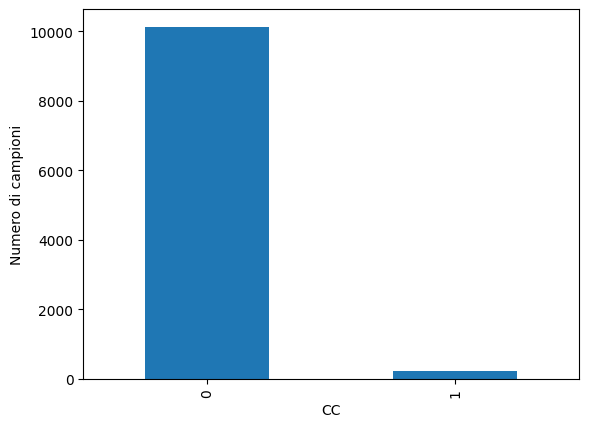

In [17]:
# sns.histplot(df['CC'], legend=True, color='yellow')


# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['CC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('CC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()



####Class Data Should Be Private

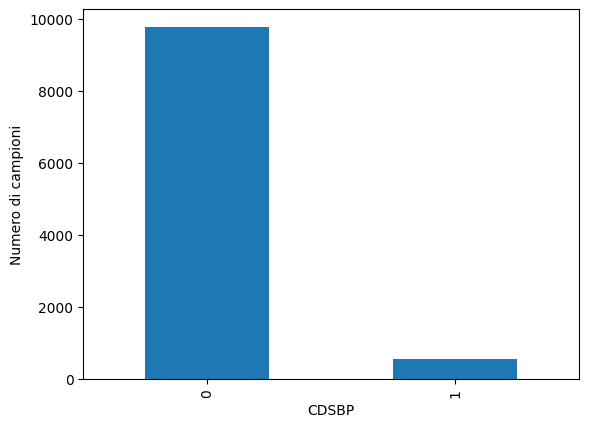

In [18]:
# sns.histplot(df['CDSBP'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['CDSBP'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('CDSBP')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Large Class

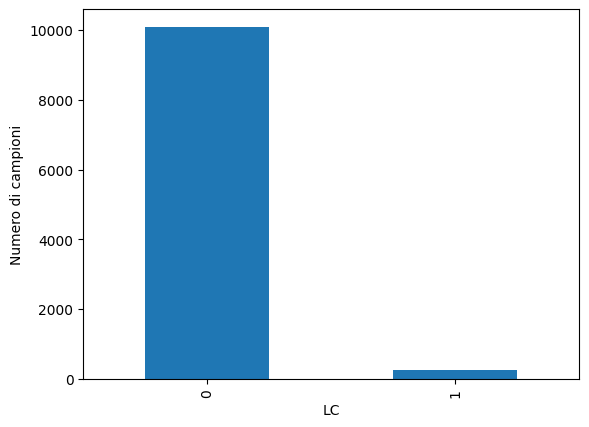

In [19]:
# sns.histplot(df['LC'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['LC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('LC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Lazy Class

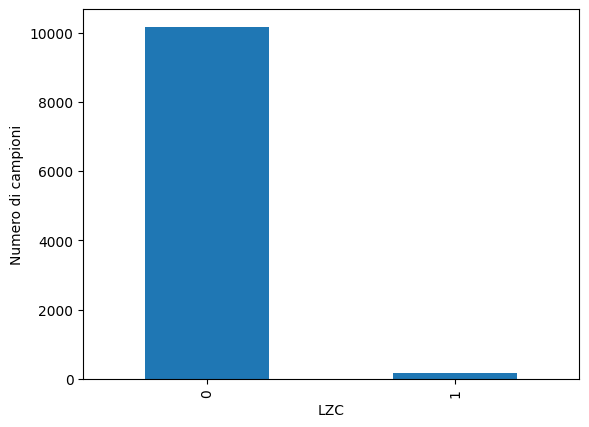

In [20]:
# sns.histplot(df['LZC'], legend=True, color='yellow')
# sns.histplot(df['CDSBP'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['LZC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('LZC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Refused Bequest

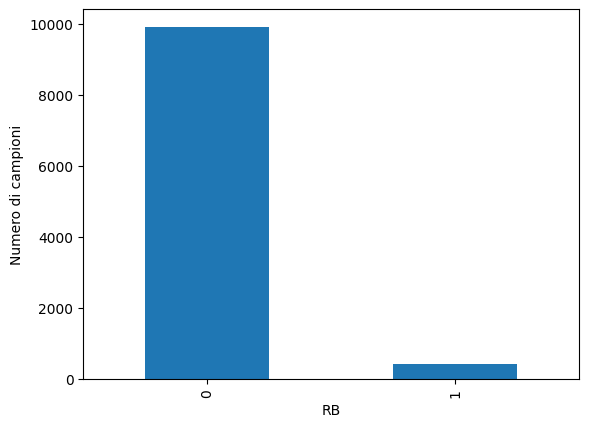

In [21]:
# sns.histplot(df['RB'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['RB'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('RB')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Spaghetti Code

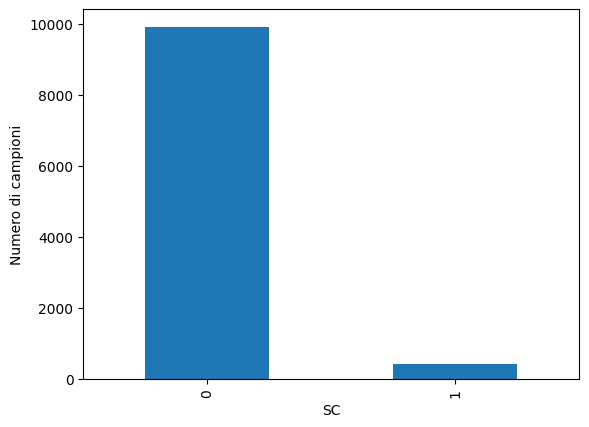

In [22]:
# sns.histplot(df['SC'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['RB'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('SC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()


####The dataset is highly unbalanced, but to avoid the introducing of overfitting or underfitting, after extensive research, it has been decided to avoid the balancing the dataset.

In [23]:
import pandas as pd
import random

def create_filtered_dataframe(input_dataframe, required_cols, num_instances=4000):
    # Filtra le istanze con almeno un 1 nelle colonne richieste
    filtered_df = input_dataframe[input_dataframe[required_cols].sum(axis=1) >= 1].copy()
    # Verifica e rimuovi eventuali duplicati
    filtered_df.drop_duplicates(inplace=True)
    # Seleziona casualmente altre istanze con tutte le colonne a 0 senza duplicati
    remaining_instances = num_instances - len(filtered_df)
    if remaining_instances > 0:
        zero_instances = input_dataframe[input_dataframe[required_cols].sum(axis=1) == 0]
        if len(zero_instances) < remaining_instances:
            raise ValueError("Non ci sono abbastanza istanze con tutte le colonne a 0.")

        # Rimuovi eventuali duplicati tra le istanze con tutte le colonne a 0
        zero_instances = zero_instances.drop_duplicates()

        # Seleziona casualmente le istanze con tutte le colonne a 0
        random_zero_instances = zero_instances.sample(remaining_instances)
        filtered_df = pd.concat([filtered_df, random_zero_instances])

    # Riduci il dataframe alle prime 4000 istanze, se necessario
    if len(filtered_df) > num_instances:
        filtered_df = filtered_df.sample(num_instances)

    # Reimposta gli indici in modo sequenziale a partire da 1
    filtered_df.reset_index(drop=True, inplace=True)

    return filtered_df

# Esempio di utilizzo:
# Supponiamo che il tuo dataframe originale si chiami 'df'
required_columns = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
reduced_dataset = create_filtered_dataframe(df, required_columns)


In [24]:
def count_duplicate_instances(df):
    # Trova le righe duplicate nel DataFrame
    duplicate_rows = df[df.duplicated()]

    # Conta il numero totale di righe duplicate
    num_duplicates = len(duplicate_rows)

    print("Numero di istanze duplicate nel DataFrame: ", num_duplicates)
    return num_duplicates
count_duplicate_instances(reduced_dataset)

Numero di istanze duplicate nel DataFrame:  0


0

In [25]:
def count_duplicate_instances_with_condition(df):
    # Trova le righe duplicate nel DataFrame con almeno una colonna uguale a 1 tra CDSBP, CC, LC, LZC, RB, SC
    condition = (df['CDSBP'] == 1) | (df['CC'] == 1) | (df['LC'] == 1) | (df['LZC'] == 1) | (df['RB'] == 1) | (df['SC'] == 1)
    duplicate_rows = df[condition & df.duplicated()]

    # Conta il numero totale di righe duplicate con la condizione specificata
    num_duplicates = len(duplicate_rows)

    print("Numero di istanze duplicate con almeno una colonna uguale a 1: ", num_duplicates)
    return num_duplicates

count_duplicate_instances_with_condition(reduced_dataset)


Numero di istanze duplicate con almeno una colonna uguale a 1:  0


0

In [26]:
reduced_dataset

,Project_name,Component_name,Contenuto,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.IvyBuildList,public ivybuildlist ivytask { private list bui...,26.0,68.0,2.0,306.0,21.0,96.0,389.0,...,10.840000,68.0,0.0,12.0,0,0,0,0,0,1
1,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.IvyPostResolveTask,public abstract ivypostresolvetask ivytask { p...,14.0,69.0,2.0,258.0,25.0,85.0,526.0,...,7.851852,69.0,0.0,18.0,0,0,0,0,0,1
2,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.IvyPublish,public ivypublish ivytask { private string org...,19.0,75.0,2.0,313.0,4.0,64.0,769.0,...,5.727273,75.0,0.0,20.0,0,0,0,0,0,1
3,ant-ivy-2.0.0-alpha2,org.apache.ivy.ant.IvyResolve,public ivyresolve ivytask { private file file ...,14.0,62.0,2.0,240.0,115.0,52.0,583.0,...,6.714286,62.0,0.0,18.0,0,0,0,0,0,1
4,ant-ivy-2.0.0-alpha2,org.apache.ivy.core.resolve.IvyNode,public ivynode comparable { private final patt...,37.0,229.0,1.0,834.0,194.0,317.0,3030.0,...,9.180723,229.0,0.0,31.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,xerces2-j-Xerces-J_2_3_0,org.apache.wml.WMLElement,public wmlelement element { public setid(strin...,1.0,5.0,1.0,17.0,74.0,0.0,6.0,...,2.500000,5.0,0.0,2.0,0,0,0,0,0,0
3996,xerces2-j-Xerces-J_2_3_0,org.apache.xerces.util.DOMEntityResolverWrapper,public domentityresolverwrapper xmlentityresol...,9.0,11.0,1.0,66.0,6.0,13.0,4.0,...,11.750000,11.0,0.0,2.0,0,0,0,0,0,0
3997,hsqldb-2.2.8,org.hsqldb.persist.PersistentStoreCollectionSe...,public persistentstorecollectionsessionimpleme...,10.0,56.0,1.0,223.0,3.0,69.0,44.0,...,13.062500,56.0,0.0,8.0,0,0,0,0,0,0
3998,xerces2-j-Xerces-J_2_3_0,org.w3c.dom.ranges.RangeException,public rangeexception runtimeexception { publi...,0.0,1.0,2.0,19.0,58.0,0.0,0.0,...,4.000000,1.0,0.0,0.0,0,0,0,0,0,0


In [27]:
# reduced_dataset.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/redDataset.csv", index=False)

##In this section, will be presented various models, their implementations and the metrics that will be used in the final test to understand which model and which approach works best for identifying code smells.

In [28]:
def get_class_embedding(class_text, word2vec_model):
    words = str(class_text).split()
    embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return None

In [29]:
def train_random_forest(X_train, Y_train, X_test, Y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)

    precision = precision_score(Y_test, y_pred, average='macro')
    accuracy = accuracy_score(Y_test, y_pred)
    mcc = matthews_corrcoef(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred, average='macro')
    f1 = f1_score(Y_test, y_pred, average='macro')

    return y_pred, precision, accuracy, mcc, recall, f1

In [30]:
def train_word2vec(X_train_comp, X_test_comp, Y_train, Y_test):
    sentences = [str(text).split() for text in X_train_comp]
    word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)

    X_train_embeddings = X_train_comp.apply(lambda x: get_class_embedding(x, word2vec_model)).dropna()
    X_test_embeddings = X_test_comp.apply(lambda x: get_class_embedding(x, word2vec_model)).dropna()

    classifier = RandomForestClassifier()
    classifier.fit(list(X_train_embeddings), Y_train)

    predictions = classifier.predict(list(X_test_embeddings))

    precision = precision_score(Y_test, predictions, average='macro')
    accuracy = accuracy_score(Y_test, predictions)
    mcc = matthews_corrcoef(Y_test, predictions)
    recall = recall_score(Y_test, predictions, average='macro')
    f1 = f1_score(Y_test, predictions, average='macro')

    return predictions, precision, accuracy, mcc, recall, f1

In [31]:
import torch
import torch.nn as nn

def train_codebert(X_train_comp, X_test_comp, Y_train, Y_test):
    # Caricamento del tokenizer e del modello pre-addestrato CodeBERT
    tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
    model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Tokenizzazione del set di addestramento
    train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length=512)
    train_labels = torch.tensor(Y_train.values)

    # Tokenizzazione del set di test
    test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length=512)
    test_labels = torch.tensor(Y_test.values)

    # Creazione dell'attention mask per i dati tokenizzati
    train_attention_mask = torch.tensor(train_encodings['attention_mask'])
    test_attention_mask = torch.tensor(test_encodings['attention_mask'])

    # Conversione dei dati tokenizzati in tensori PyTorch
    train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
    train_attention_mask = train_attention_mask.to(device)
    train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

    val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
    val_attention_mask = test_attention_mask.to(device)
    val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

    # Creazione del dataset di addestramento e validazione
    train_dataset = TensorDataset(train_inputs, train_attention_mask, train_labels)
    val_dataset = TensorDataset(val_inputs, val_attention_mask, val_labels)

    # Crea i dataloader con la nuova batch_size
    batch_size = 1
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Creazione dell'ottimizzatore
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Definizione della funzione di perdita
    loss_function = nn.BCEWithLogitsLoss()

    # Addestramento del modello
    model.to(device)
    model.train()

    for epoch in range(3):
        for batch in train_dataloader:
            optimizer.zero_grad()

            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            labels = labels.float()

            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_function(logits.squeeze(), labels.squeeze())  # Calcola la loss tra logits e etichette
            loss.backward()
            optimizer.step()

            # Libera la memoria GPU
            del inputs, attention_mask, labels
            torch.cuda.empty_cache()

    # Fine training
    predictions = []

    model.eval()  # Imposta il modello in modalità valutazione

    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la valutazione
        for batch in val_dataloader:
            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device)

            val_outputs = model(inputs, attention_mask=attention_mask)
            val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()
            val_predicted_labels = val_predicted_labels.flatten()
            if val_predicted_labels.dim() > 0:  # Verifica la dimensione del tensore
                predictions.extend(val_predicted_labels.cpu().numpy())
            del inputs, attention_mask, val_outputs, val_predicted_labels
            torch.cuda.empty_cache()

        predictions = np.array(predictions)
        test_labels = test_labels.cpu().numpy()

    precision = precision_score(test_labels, predictions, average='macro')
    accuracy = accuracy_score(test_labels, predictions)
    mcc = matthews_corrcoef(test_labels, predictions)
    recall = recall_score(test_labels, predictions, average='macro')
    f1 = f1_score(test_labels, predictions, average='macro')
    print("Precision",precision)
    print("accuracy",accuracy)
    print("mcc",mcc)
    print("f1",f1)
    print("recall",recall)
    return predictions, precision, accuracy, mcc, recall, f1


In [32]:
def main():
    code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
    RF_final_df = pd.DataFrame()
    W2V_final_df = pd.DataFrame()
    CB_final_df = pd.DataFrame()
    RF_Trad_predictions = {}
    RF_metrics = {}
    RF_WTV_predictions = {}
    RF_WTV_metrics = {}
    CB_predictions = {}
    CB_metrics = {}

    for project in projects:
        print("Current project:", project)
        project_df = reduced_dataset[reduced_dataset['Project_name'] == project]
        if len(project_df) == 0:
            continue

        RF_Trad_predictions[project] = {}
        RF_metrics[project] = {}
        RF_WTV_predictions[project] = {}
        RF_WTV_metrics[project] = {}
        CB_predictions[project] = {}
        CB_metrics[project] = {}

        for smell in code_smells:
            print("Current code smell:", smell)

            X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC'])
            y = project_df[str(smell)]

            X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

            c = 0
            for x in Y_test:
                if x == 1:
                    c += 1
            if c < 2:
                continue

            X_train_comp = X_train['Contenuto']
            X_test_comp = X_test['Contenuto']

            X_train.drop(columns=['Contenuto', 'Project_name', 'Component_name'], inplace=True)
            X_test.drop(columns=['Contenuto', 'Project_name', 'Component_name'], inplace=True)

            normalizer = MinMaxScaler()

            X_train_normalized = normalizer.fit_transform(X_train)
            X_test_normalized = normalizer.transform(X_test)

            y_pred, precision, accuracy, mcc, recall, f1 = train_random_forest(X_train_normalized, Y_train,
                                                                                X_test_normalized, Y_test)

            RF_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            RF_Trad_predictions[project][smell] = y_pred

            RF_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [RF_Trad_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            predictions, precision, accuracy, mcc, recall, f1 = train_word2vec(X_train_comp, X_test_comp, Y_train,
                                                                                Y_test)

            RF_WTV_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            RF_WTV_predictions[project][smell] = predictions

            W2V_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [RF_WTV_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            predictions, precision, accuracy, mcc, recall, f1 = train_codebert(X_train_comp, X_test_comp, Y_train,
                                                                               Y_test)

            CB_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            CB_predictions[project][smell] = predictions

            CB_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [CB_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            RF_final_df = pd.concat([RF_final_df, RF_temp_pred], ignore_index=True)
            W2V_final_df = pd.concat([W2V_final_df, W2V_temp_pred], ignore_index=True)
            CB_final_df = pd.concat([CB_final_df, CB_temp_pred], ignore_index=True)

            predictions_list = [RF_Trad_predictions[project][smell], RF_WTV_predictions[project][smell]]
            predictions_array = np.array(predictions_list)
            _, p_value = friedmanchisquare(*predictions_array.T)

            print("Friedman test p-value for", project, smell, ":", p_value)

    RF_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_result.csv", index=False)
    W2V_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_W2V_results.csv", index=False)
    CB_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/CB_results.csv", index=False)


In [ ]:
main()

Current project: ant-ivy-2.0.0-alpha2
Current code smell: CDSBP
Current code smell: CC
Current code smell: LC
Current code smell: LZC
Current code smell: RB
Current code smell: SC
Current project: ant-rel-1.8.3
Current code smell: CDSBP


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/pytho

Precision 0.4891304347826087
accuracy 0.9782608695652174
mcc 0.0
f1 0.4945054945054945
recall 0.5
Friedman test p-value for ant-rel-1.8.3 CDSBP : 0.48393141641351145
Current code smell: CC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist

Precision 0.4927536231884058
accuracy 0.9855072463768116
mcc 0.0
f1 0.4963503649635037
recall 0.5
Friedman test p-value for ant-rel-1.8.3 CC : nan
Current code smell: LC
Current code smell: LZC
Current code smell: RB


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist

Precision 0.47101449275362317
accuracy 0.9420289855072463
mcc 0.0
f1 0.48507462686567165
recall 0.5
Friedman test p-value for ant-rel-1.8.3 RB : nan
Current code smell: SC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Precision 0.8326153846153846
accuracy 0.8840579710144928
mcc 0.5214181844517154
f1 0.7444444444444445
recall 0.7043478260869566
Friedman test p-value for ant-rel-1.8.3 SC : 0.4839314164135512
Current project: cassandra-cassandra-1.0.0
Current code smell: CDSBP


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# import torch

# Inserisci qui il tuo dataframe "reduced_dataset" e la lista "projects"

# code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']

# Dataframe per i risultati finali
# RF_final_df = pd.DataFrame()
# W2V_final_df = pd.DataFrame()
# CB_final_df = pd.DataFrame()

# Dizionario per salvare le predizioni
# RF_Trad_predictions = {}
# RF_WTV_predictions = {}
# CB_predictions = {}

# Dizionario per salvare le metriche
# RF_metrics = {}
# RF_WTV_metrics = {}
# CB_metrics = {}

# Loop attraverso i progetti
# for project in projects:
#     print("Current project:", project)

#     Caricamento dei dati specifici del progetto
#     project_df = df[df['Project_name'] == project]
#     if len(project_df) == 0:
#         continue

#     Inizializza i dizionari per il progetto corrente
#     RF_Trad_predictions[project] = {}
#     RF_metrics[project] = {}

#     RF_WTV_predictions[project] = {}
#     RF_WTV_metrics[project] = {}

#     CB_predictions[project] ={}
#     CB_metrics[project] ={}

#     Loop attraverso i code smell
#     for smell in code_smells:
#         print("Current code smell:", smell)

#         X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC'])
#         y = project_df[str(smell)]

#         X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=1)


#         c = 0
#         for x in Y_test:
#             if(x == 1):
#                 c += 1
#         if(c < 2):
#             continue

#        Dati per CodeBert
#         X_train_comp = X_train['Contenuto']
#         X_test_comp = X_test['Contenuto']

#         X_train.drop(columns=['Contenuto', 'Project_name', 'Component_name'], inplace=True)
#         X_test.drop(columns=['Contenuto', 'Project_name', 'Component_name'], inplace=True)

#         normalizer = MinMaxScaler()

#         X_train_normalized = normalizer.fit_transform(X_train)
#         X_test_normalized = normalizer.transform(X_test)

#        Fitting vari modelli

#        RandomForest Tradizionale
#         rf = RandomForestClassifier(n_estimators=100, random_state=42)
#         rf.fit(X_train_normalized, Y_train)
#         y_pred = rf.predict(X_test_normalized)

#         Metriche per RandomForest Tradizionale
#         precision = precision_score(Y_test, y_pred, average='macro')
#         accuracy = accuracy_score(Y_test, y_pred)
#         mcc = matthews_corrcoef(Y_test, y_pred)
#         recall = recall_score(Y_test, y_pred, average='macro')
#         f1 = f1_score(Y_test, y_pred, average='macro')

#         Salva le metriche per lo smell corrente nel progetto corrente
#         RF_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         Salva le predizioni per lo smell corrente nel progetto corrente
#         RF_Trad_predictions[project][smell] = y_pred

#         Salva i risultati
#         RF_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [RF_Trad_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         word2vec per RandomForest
#         Prepara i dati di addestramento
#         sentences = [str(text).split() for text in X_train_comp]

#         Addestra il modello Word2Vec
#         word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)

#         Funzione per ottenere gli embeddings di una classe Java
#         def get_class_embedding(class_text):
#             words = str(class_text).split()
#             embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
#             if embeddings:
#                 return sum(embeddings) / len(embeddings)
#             else:
#                 return None

#         Trasforma X_train_comp in embeddings
#         X_train_embeddings = X_train_comp.apply(get_class_embedding)

#         Rimuovi le righe che non hanno embeddings
#         X_train_embeddings = X_train_embeddings.dropna()

#        Trasforma X_test_comp in embeddings
#         X_test_embeddings = X_test_comp.apply(get_class_embedding)

#         Rimuovi le righe che non hanno embeddings
#         X_test_embeddings = X_test_embeddings.dropna()

#         Crea e addestra il classificatore RandomForest
#         classifier = RandomForestClassifier()
#         classifier.fit(list(X_train_embeddings), Y_train)

#        Effettua le previsioni sul set di test
#         predictions = classifier.predict(list(X_test_embeddings))

#         Metriche per RandomForest con word2vec
#         precision = precision_score(Y_test, predictions, average='macro')
#         accuracy = accuracy_score(Y_test, predictions)
#         mcc = matthews_corrcoef(Y_test, predictions)
#         recall = recall_score(Y_test, predictions, average='macro')
#         f1 = f1_score(Y_test, predictions, average='macro')

#         Salva le metriche per lo smell corrente nel progetto corrente
#         RF_WTV_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         Salva le predizioni per lo smell corrente nel progetto corrente
#         RF_WTV_predictions[project][smell] = predictions

#         W2V_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [RF_WTV_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         Caricamento del tokenizer e del modello pre-addestrato CodeBERT
#         tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
#         model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         Tokenizzazione del set di addestramento
#         train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length=512)
#         train_labels = torch.tensor(Y_train.values)

#         Tokenizzazione del set di test
#         test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length=512)
#         test_labels = torch.tensor(Y_test.values)

#         Creazione dell'attention mask per i dati tokenizzati
#         train_attention_mask = torch.tensor(train_encodings['attention_mask'])
#         test_attention_mask = torch.tensor(test_encodings['attention_mask'])

#         Conversione dei dati tokenizzati in tensori PyTorch
#         train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
#         train_attention_mask = train_attention_mask.to(device)
#         train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

#         val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
#         val_attention_mask = test_attention_mask.to(device)
#         val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

#         Creazione del dataset di addestramento e validazione
#         train_dataset = TensorDataset(train_inputs, train_attention_mask, train_labels)
#         val_dataset = TensorDataset(val_inputs, val_attention_mask, val_labels)

#         Crea i dataloader con la nuova batch_size
#         batch_size = 1
#         train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#         Creazione dell'ottimizzatore
#         optimizer = AdamW(model.parameters(), lr=1e-5)

#         Definizione della funzione di perdita
#         loss_function = nn.BCEWithLogitsLoss()

#         Addestramento del modello
#         model.to(device)
#         model.train()

#         for epoch in range(3):
#             for batch in train_dataloader:
#                 optimizer.zero_grad()

#                 inputs = batch[0].to(device)
#                 attention_mask = batch[1].to(device)
#                 labels = batch[2].to(device)
#                 labels = labels.float()

#                 outputs = model(inputs, attention_mask=attention_mask)
#                 logits = outputs.logits

#                 loss = loss_function(logits.squeeze(), labels.squeeze())  # Calcola la loss tra logits e etichette
#                 loss.backward()
#                 optimizer.step()

#                 Libera la memoria GPU
#                 del inputs, attention_mask, labels
#                 torch.cuda.empty_cache()

#         Fine training
#         predictions = []
#         model.eval()
#         for batch in val_dataloader:
#             inputs = batch[0].to(device)
#             attention_mask = batch[1].to(device)

#             val_outputs = model(inputs, attention_mask=attention_mask)
#             val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()
#             val_predicted_labels = val_predicted_labels.flatten()
#             if val_predicted_labels.dim() > 0:  # Verifica la dimensione del tensore
#                 predictions.extend(val_predicted_labels.cpu().numpy())

#             del inputs, attention_mask, val_outputs, val_predicted_labels
#             torch.cuda.empty_cache()

#         predictions = np.array(predictions)
#         test_labels = test_labels.cpu().numpy()

#         precision = precision_score(test_labels, predictions, average='macro')
#         accuracy = accuracy_score(test_labels, predictions)
#         mcc = matthews_corrcoef(test_labels, predictions)
#         recall = recall_score(test_labels, predictions, average='macro')
#         f1 = f1_score(test_labels, predictions, average='macro')
#         print("Precision",precision)
#         print("accuracy",accuracy)
#         print("mcc",mcc)
#         print("f1",f1)
#         print("recall",recall)

#         CB_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         CB_predictions[project][smell] = predictions

#         del predictions
#         torch.cuda.empty_cache()

#         CB_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [CB_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         RF_final_df = pd.concat([RF_final_df, RF_temp_pred], ignore_index=True)
#         W2V_final_df = pd.concat([W2V_final_df, W2V_temp_pred], ignore_index=True)
#         CB_final_df = pd.concat([CB_final_df, CB_temp_pred], ignore_index=True)

#         Applica il test di Friedman per il progetto corrente e gli smell correnti
#         predictions_list = [RF_Trad_predictions[project][smell], RF_WTV_predictions[project][smell]] # , CB_predictions[project][smell]
#         predictions_array = np.array(predictions_list)

# # import torch

# # code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']

# # # Dataframe per i risultati finali
# # RF_final_df = pd.DataFrame()
# # W2V_final_df = pd.DataFrame()
# # CB_final_df = pd.DataFrame()

# # # Dizionario per salvare le predizioni
# # RF_Trad_predictions = {}
# # RF_WTV_predictions = {}
# # CB_predictions = {}

# # # Dizionario per salvare le metriche
# # RF_metrics = {}
# # RF_WTV_metrics = {}
# # CB_metrics = {}

# # # Loop attraverso i progetti
# # for project in projects:
# #     print("Current project:", project)

# #     # Caricamento dei dati specifici del progetto
# #     project_df = reduced_dataset[reduced_dataset['Project_name'] == project]
# #     if len(project_df) == 0:
# #         continue

# #     # Inizializza i dizionari per il progetto corrente
# #     RF_Trad_predictions[project] = {}
# #     RF_metrics[project] = {}

# #     RF_WTV_predictions[project] = {}
# #     RF_WTV_metrics[project] = {}

# #     CB_predictions[project] ={}
# #     CB_metrics[project] ={}

# #     # Loop attraverso i code smell
# #     for smell in code_smells:
# #         print("Current code smell:", smell)

# #         X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC'])
# #         y = project_df[str(smell)]

# #         X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# #         ##
# #         c = 0
# #         for x in Y_test:
# #           if(x == 1):
# #             c += 1
# #         if(c < 2):
# #           continue

# #         #Dati per CodeBert
# #         X_train_comp = X_train['Component']
# #         X_test_comp = X_test['Component']

# #         X_train.drop(columns=['Component', 'Project_name'], inplace=True)
# #         X_test.drop(columns=['Component', 'Project_name'], inplace=True)

# #         normalizer = MinMaxScaler()

# #         X_train_normalized = normalizer.fit_transform(X_train)
# #         X_test_normalized = normalizer.transform(X_test)

# #         # Fitting vari modelli

# #         # RandomForest Tradizionale
# #         rf = RandomForestClassifier(n_estimators=100, random_state=42)
# #         rf.fit(X_train_normalized, Y_train)
# #         y_pred = rf.predict(X_test_normalized)

# #         # Metriche per RandomForest Tradizionale
# #         precision = precision_score(Y_test, y_pred, average='macro')
# #         accuracy = accuracy_score(Y_test, y_pred)
# #         mcc = matthews_corrcoef(Y_test, y_pred)
# #         recall = recall_score(Y_test, y_pred, average='macro')
# #         f1 = f1_score(Y_test, y_pred, average='macro')

# #         # Salva le metriche per lo smell corrente nel progetto corrente
# #         RF_metrics[project][smell] = {
# #             "Precision": precision,
# #             "Accuracy": accuracy,
# #             "Recall": recall,
# #             "F1": f1,
# #             "MCC": mcc
# #         }

# #         # Salva le predizioni per lo smell corrente nel progetto corrente
# #         RF_Trad_predictions[project][smell] = y_pred

# #         # Salva i risultati
# #         RF_temp_pred = pd.DataFrame({
# #             'Project_name': [project],
# #             'Smell': [smell],
# #             'Y_pred': [RF_Trad_predictions[project][smell].tolist()],
# #             'Y_test': [Y_test.tolist()],
# #             'precision': precision,
# #             'accuracy': accuracy,
# #             'recall': recall,
# #             'f1': f1,
# #             'mcc': mcc,
# #         })

# #         # word2vec per RandomForest
# #         # Prepara i dati di addestramento
# #         sentences = [str(text).split() for text in X_train_comp]

# #         # Addestra il modello Word2Vec
# #         word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)

# #         # Funzione per ottenere gli embeddings di una classe Java
# #         def get_class_embedding(class_text):
# #             words = str(class_text).split()
# #             embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
# #             if embeddings:
# #                 return sum(embeddings) / len(embeddings)
# #             else:
# #                 return None

# #         # Trasforma X_train_comp in embeddings
# #         X_train_embeddings = X_train_comp.apply(get_class_embedding)

# #         # Rimuovi le righe che non hanno embeddings
# #         X_train_embeddings = X_train_embeddings.dropna()

# #         # Trasforma X_test_comp in embeddings
# #         X_test_embeddings = X_test_comp.apply(get_class_embedding)

# #         # Rimuovi le righe che non hanno embeddings
# #         X_test_embeddings = X_test_embeddings.dropna()

# #         # Crea e addestra il classificatore RandomForest
# #         classifier = RandomForestClassifier()
# #         classifier.fit(list(X_train_embeddings), Y_train)

# #         # Effettua le previsioni sul set di test
# #         predictions = classifier.predict(list(X_test_embeddings))

# #         # Metriche per RandomForest con word2vec
# #         precision = precision_score(Y_test, predictions, average='macro')
# #         accuracy = accuracy_score(Y_test, predictions)
# #         mcc = matthews_corrcoef(Y_test, predictions)
# #         recall = recall_score(Y_test, predictions, average='macro')
# #         f1 = f1_score(Y_test, predictions, average='macro')

# #         # Salva le metriche per lo smell corrente nel progetto corrente
# #         RF_WTV_metrics[project][smell] = {
# #             "Precision": precision,
# #             "Accuracy": accuracy,
# #             "Recall": recall,
# #             "F1": f1,
# #             "MCC": mcc
# #         }

# #         # Salva le predizioni per lo smell corrente nel progetto corrente
# #         RF_WTV_predictions[project][smell] = predictions

# #         W2V_temp_pred = pd.DataFrame({
# #             'Project_name': [project],
# #             'Smell': [smell],
# #             'Y_pred': [RF_WTV_predictions[project][smell].tolist()],
# #             'Y_test': [Y_test.tolist()],
# #             'precision': precision,
# #             'accuracy': accuracy,
# #             'recall': recall,
# #             'f1': f1,
# #             'mcc': mcc,
# #         })

# #         # Caricamento del tokenizer e del modello pre-addestrato CodeBERT
# #         tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
# #         model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)

# #         # Tokenizzazione del set di addestramento
# #         train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length = 512)
# #         train_labels = pt.tensor(Y_train.values)
# #         # Tokenizzazione del set di test
# #         test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length = 512)
# #         test_labels = pt.tensor(Y_test.values)

# #         # Inizio training


# #         # Imposta la dimensione del batch desiderata
# #         batch_size = 7

# #         # Definizione del dispositivo (GPU o CPU)
# #         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# #         # Conversione dei dati tokenizzati in tensori PyTorch
# #         train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
# #         train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

# #         val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
# #         val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

# #         # Creazione del dataset di addestramento
# #         train_dataset = TensorDataset(train_inputs, train_labels)

# #         # Creazione del dataset di validazione
# #         val_dataset = TensorDataset(val_inputs, val_labels)

# #         # Crea i dataloader con la nuova batch_size
# #         train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# #         val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# #         # Creazione dell'ottimizzatore
# #         optimizer = AdamW(model.parameters(), lr=1e-5)

# #         # Definizione della funzione di perdita
# #         loss_function = loss_function = nn.BCEWithLogitsLoss()

# #         # Addestramento del modello
# #         model.to(device)
# #         model.train()

# #         for epoch in range(3):
# #             for batch in train_dataloader:
# #                 optimizer.zero_grad()

# #                 inputs = batch[0].to(device)
# #                 labels = batch[1].to(device)
# #                 labels = labels.float()

# #                 outputs = model(inputs)
# #                 logits = outputs.logits

# #                 loss = loss_function(logits.squeeze(), labels.squeeze())  # Calcola la loss tra logits e etichette
# #                 loss.backward()
# #                 optimizer.step()

# #                 #print(f"Epoch {epoch+1} - Loss: {loss.item()}")
# #                 # Libera la memoria GPU
# #                 del inputs, labels
# #                 torch.cuda.empty_cache()

# #         # Fine training
# #         predictions = []

# #         for batch in val_dataloader:
# #             inputs = batch[0].to(device)
# #             labels = batch[1].to(device)

# #             val_outputs = model(inputs)
# #             val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()

# #             if val_predicted_labels.dim() > 0:  # Verifica la dimensione del tensore
# #               predictions.extend(val_predicted_labels.cpu().numpy())

# #             del inputs, labels, val_outputs, val_predicted_labels
# #             torch.cuda.empty_cache()

# #         predictions = np.array(predictions)
# #         test_labels = test_labels.cpu().numpy()

# #         precision = precision_score(test_labels, predictions, average='macro')
# #         accuracy = accuracy_score(test_labels, predictions)
# #         mcc = matthews_corrcoef(test_labels, predictions)
# #         recall = recall_score(test_labels, predictions, average='macro')
# #         f1 = f1_score(test_labels, predictions, average='macro')

# #         CB_metrics[project][smell] = {
# #             "Precision": precision,
# #             "Accuracy": accuracy,
# #             "Recall": recall,
# #             "F1": f1,
# #             "MCC": mcc
# #         }

# #         CB_predictions[project][smell] = predictions

# #         del predictions
# #         torch.cuda.empty_cache()


# #         CB_temp_pred = pd.DataFrame({
# #             'Project_name': [project],
# #             'Smell': [smell],
# #             'Y_pred': [CB_predictions[project][smell].tolist()],
# #             'Y_test': [Y_test.tolist()],
# #             'precision': precision,
# #             'accuracy': accuracy,
# #             'recall': recall,
# #             'f1': f1,
# #             'mcc': mcc,
# #         })

# #         RF_final_df = pd.concat([RF_final_df, RF_temp_pred], ignore_index=True)
# #         W2V_final_df = pd.concat([W2V_final_df, W2V_temp_pred], ignore_index=True)
# #         CB_final_df = pd.concat([CB_final_df, CB_temp_pred], ignore_index=True)


# #         # Applica il test di Friedman per il progetto corrente e gli smell correnti
# #         predictions_list = [RF_Trad_predictions[project][smell], RF_WTV_predictions[project][smell]] # , CB_predictions[project][smell]
# #         predictions_array = np.array(predictions_list)
# #         _, p_value = friedmanchisquare(*predictions_array.T)

# #         # Stampa il p-value del test di Friedman per il progetto corrente e lo smell corrente
# #         print("Friedman test p-value for", project, smell, ":", p_value)

In [ ]:
# RF_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_result.csv", index=False)
# W2V_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_W2V_results.csv", index=False)
# CB_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/CB_results.csv", index=False)